In [ ]:
# https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

In [52]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

print(os.listdir("input/train"))

['cat.10001.jpg', 'cat.10002.jpg', 'cat.10005.jpg', 'cat.10008.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10029.jpg', 'cat.1004.jpg', 'cat.10050.jpg', 'cat.10053.jpg', 'cat.10059.jpg', 'cat.1006.jpg', 'cat.10065.jpg', 'cat.10066.jpg', 'cat.10069.jpg', 'cat.1007.jpg', 'cat.10077.jpg', 'cat.10078.jpg', 'cat.1008.jpg', 'cat.10098.jpg', 'cat.10102.jpg', 'cat.10105.jpg', 'cat.10107.jpg', 'cat.10108.jpg', 'cat.10109.jpg', 'cat.10111.jpg', 'cat.10121.jpg', 'cat.10125.jpg', 'cat.1014.jpg', 'cat.10154.jpg', 'cat.10156.jpg', 'cat.1016.jpg', 'cat.10161.jpg', 'cat.10164.jpg', 'cat.10168.jpg', 'cat.10176.jpg', 'cat.1018.jpg', 'cat.10181.jpg', 'cat.10182.jpg', 'cat.10184.jpg', 'cat.10194.jpg', 'cat.10197.jpg', 'cat.10198.jpg', 'cat.10201.jpg', 'cat.10202.jpg', 'cat.10203.jpg', 'cat.10205.jpg', 'cat.10210.jpg', 'cat.10220.jpg', 'cat.10226.jpg', 'cat.10229.jpg', 'cat.10237.jpg', 'cat.10244.jpg', 'cat.10248.jpg', 'cat.1025.jpg', 'cat.10254.jpg', 'cat.10255.jpg', 'cat.10257.jpg', 'cat.10259.jpg', 'cat

In [53]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [54]:
filenames = os.listdir("input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [55]:
df.head()


,filename,category
0,cat.10001.jpg,0
1,cat.10002.jpg,0
2,cat.10005.jpg,0
3,cat.10008.jpg,0
4,cat.10024.jpg,0


In [56]:
df.tail()

,filename,category
3995,dog.9972.jpg,1
3996,dog.9974.jpg,1
3997,dog.9979.jpg,1
3998,dog.9982.jpg,1
3999,dog.9985.jpg,1


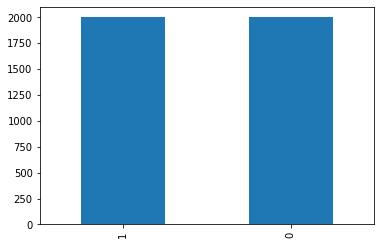

In [57]:
df['category'].value_counts().plot.bar()

In [58]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [59]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

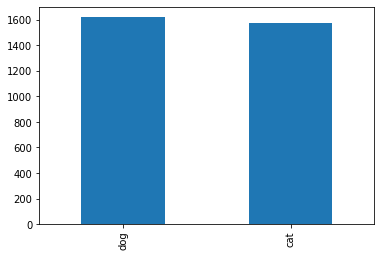

In [60]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

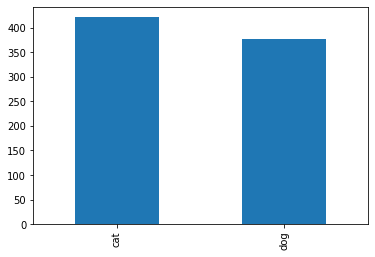

In [61]:
validate_df['category'].value_counts().plot.bar()

In [62]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [63]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 2 classes.


In [64]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


In [65]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "input/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


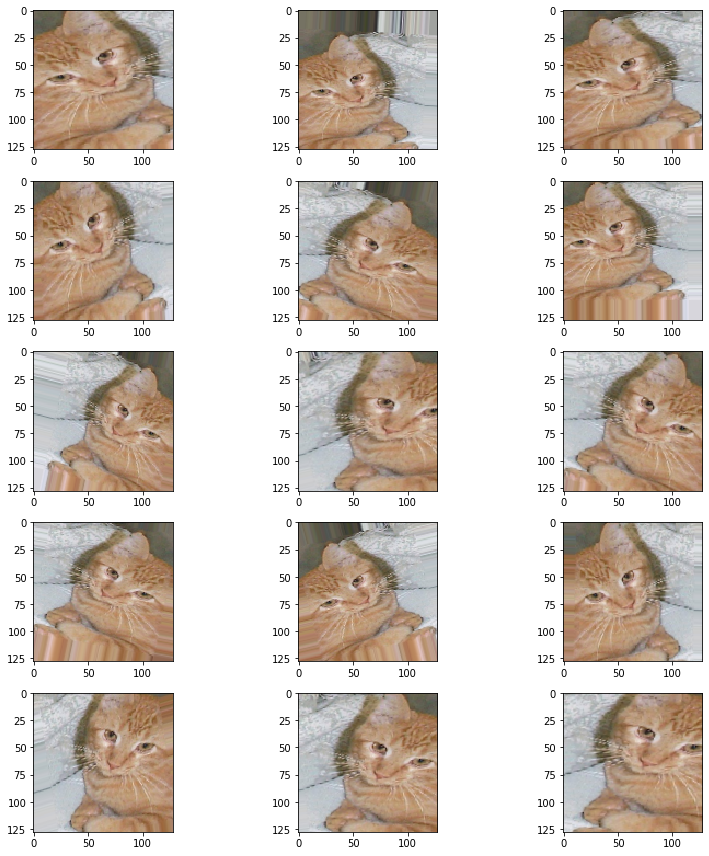

In [66]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [67]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
213/213 [==============================] - 246s 1s/step - loss: 1.1214 - acc: 0.5455 - val_loss: 0.9912 - val_acc: 0.6000
Epoch 2/50
213/213 [==============================] - 239s 1s/step - loss: 0.8076 - acc: 0.5909 - val_loss: 0.7300 - val_acc: 0.5911
Epoch 3/50
213/213 [==============================] - 240s 1s/step - loss: 0.7155 - acc: 0.6022 - val_loss: 0.8085 - val_acc: 0.6013
Epoch 4/50
213/213 [==============================] - 238s 1s/step - loss: 0.6418 - acc: 0.6479 - val_loss: 0.6848 - val_acc: 0.6522
Epoch 5/50
213/213 [==============================] - 239s 1s/step - loss: 0.6191 - acc: 0.6676 - val_loss: 0.7166 - val_acc: 0.6510
Epoch 6/50
213/213 [==============================] - 238s 1s/step - loss: 0.6062 - acc: 0.6808 - val_loss: 0.5848 - val_acc: 0.6828
Epoch 7/50
213/213 [==============================] - 237s 1s/step - loss: 0.5920 - acc: 0.6908 - val_loss: 0.8603 - val_acc: 0.5836
Epoch 8/50
213/213 [==============================] - 238s 1s/step - 

In [68]:
model.save_weights("model.h5")

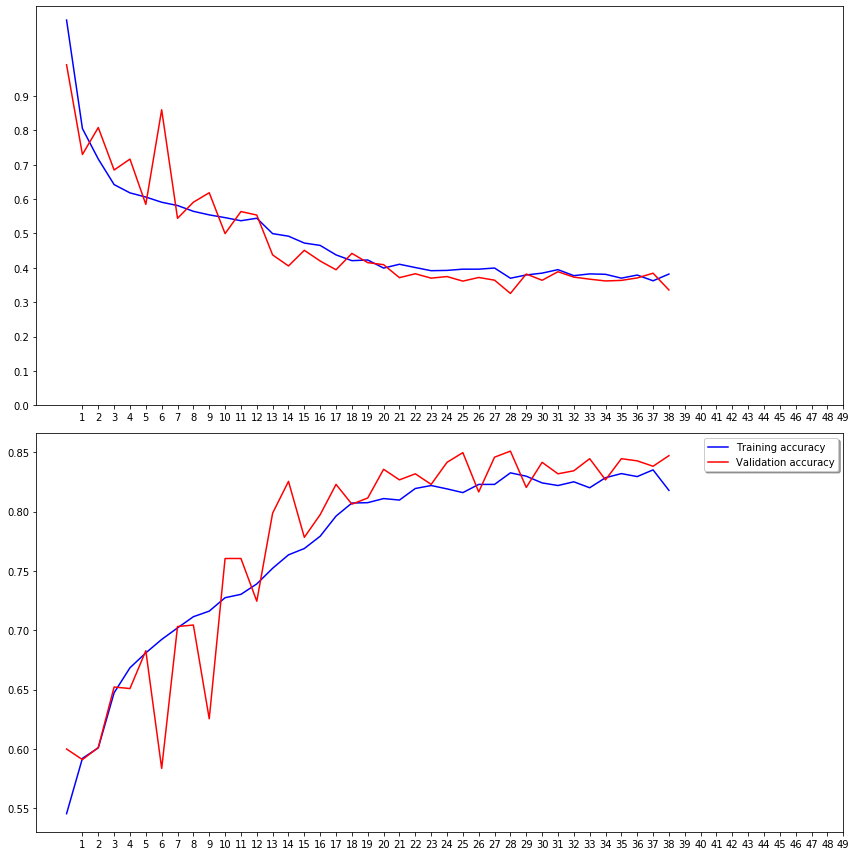

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [70]:
test_filenames = os.listdir("input/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [71]:

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "input/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 400 validated image filenames.


In [72]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

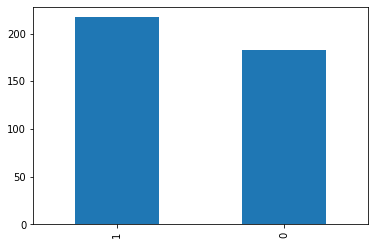

In [73]:
test_df['category'].value_counts().plot.bar()

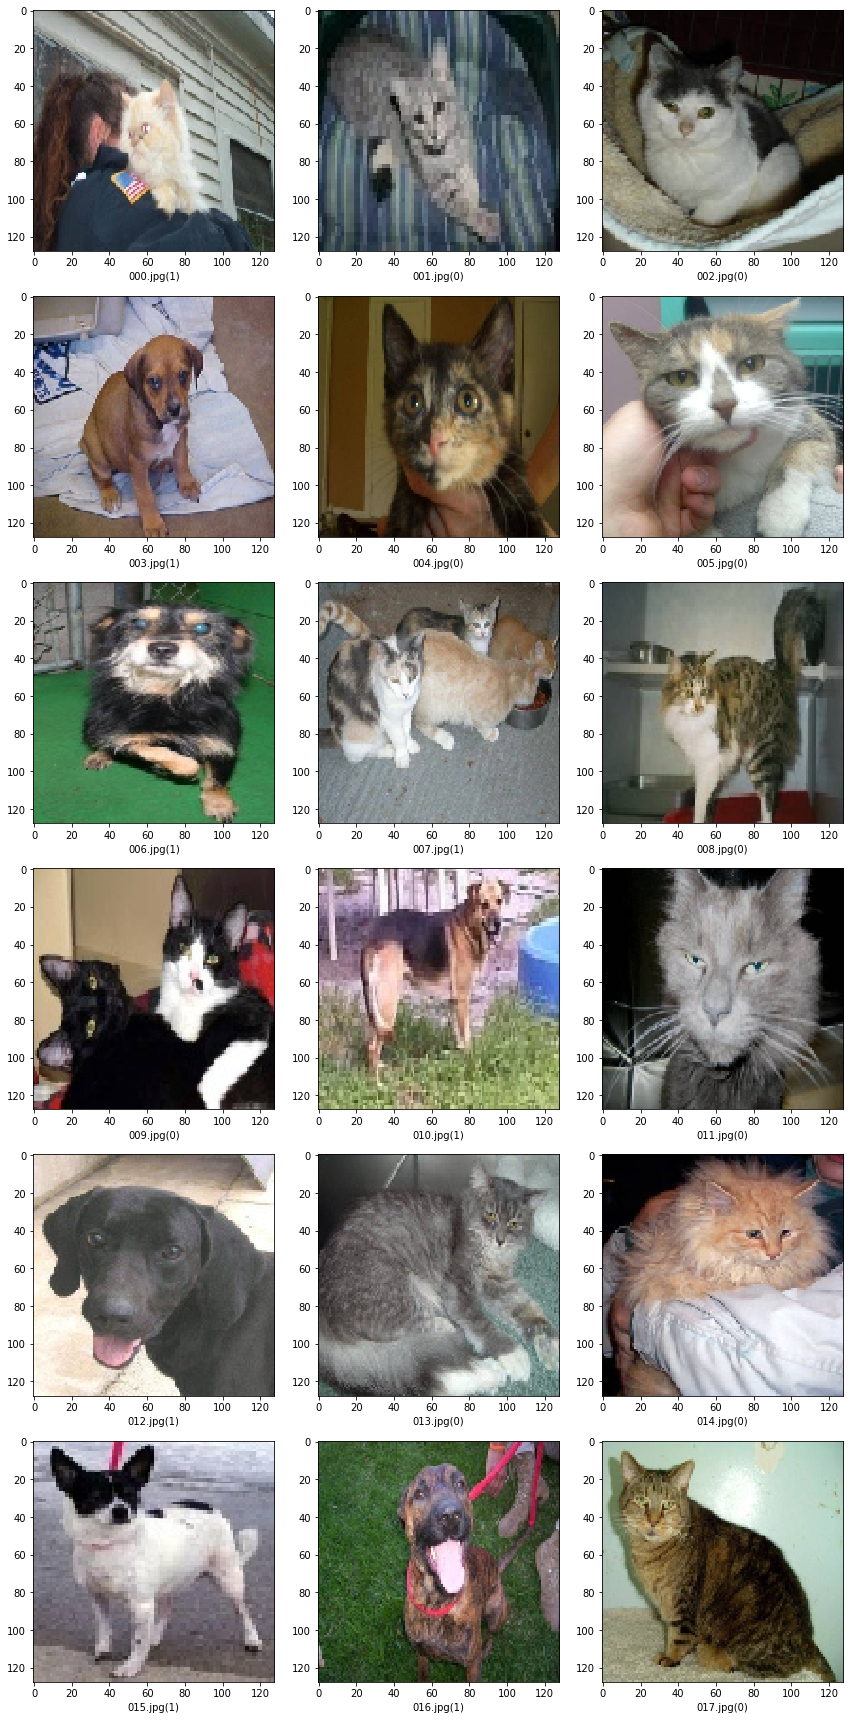

In [74]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("input/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


In [75]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('0814submission.csv', index=False)